In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib
import io
import itertools
import warnings

from brokenaxes import brokenaxes


import polars as pl
pl.Config.set_tbl_rows(100);
pl.Config.set_fmt_str_lengths(50);


In [13]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Create callset to infer from

In [14]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [15]:
sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

In [16]:
ceph_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.tsv", separator='\t')

In [7]:
%%time
reads_df_list = \
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + \
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + \
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(ceph_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]


9it [00:00, 475.08it/s]
6it [00:00, 2334.28it/s]
16it [00:00, 2482.57it/s]

CPU times: user 16 ms, sys: 10 ms, total: 26 ms
Wall time: 50 ms


In [8]:
%%time
fields = [
    'read_name',
    'read_length',
    'chrom',
    'sample_id',
    'grch37_chromosome_size_in_bp',
    'high_quality_snp_positions',
    "high_quality_snp_positions_alleles",
    "high_quality_snps_idx_transitions",
    'CO_active_interval_start',
    'CO_active_interval_end',
    'CO_active_interval_length_bp',
    'NCO_active_interval_start',
    'NCO_active_interval_end',
    'NCO_active_interval_length_bp',
    'grch37_reference_start',
    'grch38_reference_start',
    'grch37_reference_end',
    'grch38_reference_end',
    'T2T_reference_start',
    'grch37_reference_start_cM',
    'grch37_reference_end_cM',
    'CO_active_interval_start_cM',
    'CO_active_interval_end_cM',
    'CO_active_interval_crossover_prob',
    'NCO_active_interval_start_cM',
    'NCO_active_interval_end_cM',
    'NCO_active_interval_crossover_prob',
    "NCO_prob_detection_in_CO_active_interval",
    "full_read_crossover_prob",
    'AA_motif_center_pos',
    'AA_heat',
    'AA_motif_strand',
    'CL4_motif_center_pos',
    'CL4_heat',
    'CL4_motif_strand',
    'is_high_quality_read', 
    "high_quality_classification_class",
    "snp_positions_on_read", 
    "idx_transitions",
    "high_quality_classification_in_detectable_class",
    "H3K4me3_signal_mean",
    "CTCF_signal_mean",  
    "total_mismatches",
    "is_contamination",    
]

def F(reads_df):
    return (reads_df
        .select(fields)           
        .filter(pl.col("high_quality_classification_class") == "GC")
        .collect()
        .filter(~pl.col("is_contamination"))
        .filter(pl.col("is_high_quality_read"))
        .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
        .filter(pl.col("CO_active_interval_crossover_prob") > 0)
        .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)    
        .select(fields)           
    )

NCO_df = pl.concat(
    joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(F)(reads_df) for reads_df in reads_df_list
    )
)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 127 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.4min
[Paralle

CPU times: user 3min 44s, sys: 55 s, total: 4min 38s
Wall time: 7min 49s


In [9]:
NCO_df = (NCO_df
    .filter(pl.col("high_quality_classification_class") == "GC")
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch37_first_converted_marker_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
        grch38_first_converted_marker_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
    )
)

dfs = []
for [chrom], df in NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
            grch37_first_converted_marker_poses_rate = rate_map.get_rate(df["grch37_first_converted_marker_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
        )
    )
    
NCO_df = pl.concat(dfs)


In [10]:
(NCO_df
    .filter(pl.col("sample_id").is_in(ceph_sample_ids))
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        columns=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
#    .select("sample_id", "CO", "GC", "ambiguous", "CNCO") 
)

/tmp/ipykernel_397574/4087822181.py:3: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(


sample_id,GC
str,u32
"""200100""",11
"""200101""",19
"""200102""",19
"""200104""",7
"""200106""",3
"""NA12877""",44
"""NA12878""",42
"""NA12879""",31
"""NA12881""",58


# Reviewer 1

## P1: GC bias

### Make a dataframe of positions of all converted SNPs

In [10]:
%%time
converted_snps_df = (NCO_df
    .with_columns(
        (pl.col("idx_transitions").list.get(0)+1).alias("A"),
        (pl.col("idx_transitions").list.get(1) - pl.col("idx_transitions").list.get(0)).alias("B"),
    )
    .select(
        "sample_id",
        "chrom",
        "read_name",
        pl.col("snp_positions_on_read").list.slice(pl.col("A"), pl.col("B")).alias("start"),
        pl.col("AA_heat").is_not_null().alias("has_AA_DSB"),
        "snp_positions_on_read",
    )
    .explode("start")
)

CPU times: user 21.2 ms, sys: 4.76 ms, total: 26 ms
Wall time: 7.32 ms


In [11]:
len(converted_snps_df)

3018

### Cross it with the sequences

In [12]:
filenames = []
for R in rahbari_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )

for R in sudmant_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )

for R in ceph_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )
        
        
def F(filename):
    high_conf_snps_df = pl.scan_parquet(filename)
    
    df = (converted_snps_df
            .lazy()
            .join(
                (high_conf_snps_df
                    .select(
                        "read_name",
                        "start",
                        "refseq_start1",
                        "refseq_start2",    
                        "fits1_more",
                    )
                ),
                on=["read_name", "start"],
            )
        ).collect()
    
    return df

dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(filename) for filename in filenames
)
        
all_converted_snps_with_seq_df = pl.concat(dfs)

converted_snps_with_seq_df = all_converted_snps_with_seq_df.filter(
    (pl.col("refseq_start1").is_in(["G", "C"]) & pl.col("refseq_start2").is_in(["A", "T"])) |
    (pl.col("refseq_start2").is_in(["G", "C"]) & pl.col("refseq_start1").is_in(["A", "T"]))
)
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2640 out of 2640 | elapsed:  2.1min finished


In [14]:
len(all_converted_snps_with_seq_df)

3018

In [15]:
len(converted_snps_with_seq_df)

2608

In [16]:
all_converted_snps_with_seq_df.group_by(
    (pl.col("refseq_start1").is_in(["G", "C"]), pl.col("refseq_start2").is_in(["A", "T"]))
).len()

refseq_start1,refseq_start2,len
bool,bool,u32
false,false,1276
false,true,192
true,true,1332
true,false,218


In [17]:
df = (converted_snps_with_seq_df
    .select("read_name", "start", "snp_positions_on_read")
    .explode("snp_positions_on_read")
    .with_columns(min_snp_diff = (pl.col("start") - pl.col("snp_positions_on_read")).abs())
    .filter(pl.col("min_snp_diff") > 0)
    .sort("read_name", "start", "min_snp_diff")
    .group_by(["read_name", "start"], maintain_order=True)
    .first()
    .select("read_name", "start", "min_snp_diff")
)

converted_snps_with_seq_df = converted_snps_with_seq_df.join(df, on=["read_name", "start"])

In [18]:
print("# of converted SNPs:", len(converted_snps_with_seq_df))
print("# of NCO reads:", converted_snps_with_seq_df.n_unique(["read_name"]))

# of converted SNPs: 2608
# of NCO reads: 2481


In [19]:
print("# of converted SNPs in sperm:", len(converted_snps_with_seq_df.filter(~pl.col("sample_id").is_in(ceph_sample_ids))))
print("# of NCO reads in sperm:", converted_snps_with_seq_df.filter(~pl.col("sample_id").is_in(ceph_sample_ids)).n_unique(["read_name"]))

# of converted SNPs in sperm: 1815
# of NCO reads in sperm: 1692


## What is the total GC bias?

In [20]:
import statsmodels.stats.proportion

def calculate_gc_stats(df, limited_sample_ids):
    gc_stats_df = (df
        .filter(pl.col("sample_id").is_in(limited_sample_ids))
        .select(
            pl.when(pl.col("fits1_more") == 1).then(pl.col("refseq_start1")).otherwise(pl.col("refseq_start2")).alias("base")
        )
        .group_by("base")
        .len()
    )
                   
    stats_D = dict(gc_stats_df.rows())

    n_GC = stats_D.get("G", 0) + stats_D.get("C", 0)
    n_AT = stats_D.get("A", 0) + stats_D.get("T", 0)
                   
    print("n_GC, n_AT:", n_GC, n_AT)
    print("GC-bias:", n_GC / (n_GC+n_AT))
    print("CI:", statsmodels.stats.proportion.proportion_confint(n_GC, (n_GC+n_AT), method="binom_test"))
    
    return n_GC / (n_GC+n_AT), statsmodels.stats.proportion.proportion_confint(n_GC, (n_GC+n_AT), method="binom_test")

In [102]:
calculate_gc_stats(converted_snps_with_seq_df, sample_ids);

n_GC, n_AT: 1103 712
GC-bias: 0.6077134986225895
CI: (0.5848626321232496, 0.6300484892540437)


In [103]:
calculate_gc_stats(converted_snps_with_seq_df, rahbari_sample_ids);

n_GC, n_AT: 705 446
GC-bias: 0.6125108601216334
CI: (0.5838618360878662, 0.6403478237761184)


In [104]:
calculate_gc_stats(converted_snps_with_seq_df, [x for x in rahbari_sample_ids if x != "PD50523b"]);

n_GC, n_AT: 510 319
GC-bias: 0.6151990349819059
CI: (0.5814523868163729, 0.6478191261889793)


In [105]:
calculate_gc_stats(converted_snps_with_seq_df, sudmant_sample_ids);

n_GC, n_AT: 398 266
GC-bias: 0.5993975903614458
CI: (0.5610238529167411, 0.6363571634647197)


In [106]:
calculate_gc_stats(converted_snps_with_seq_df, rahbari_sample_ids + sudmant_sample_ids);

n_GC, n_AT: 1103 712
GC-bias: 0.6077134986225895
CI: (0.5848626321232496, 0.6300484892540437)


In [107]:
calculate_gc_stats(converted_snps_with_seq_df, ceph_sample_ids);

n_GC, n_AT: 352 441
GC-bias: 0.44388398486759145
CI: (0.409169510242424, 0.47918453478720857)


## Limited to AA DSBs

In [25]:
calculate_gc_stats(converted_snps_with_seq_df.filter("has_AA_DSB"), sample_ids)

n_GC, n_AT: 553 288
GC-bias: 0.6575505350772889
CI: (0.6243048146303324, 0.6891278936778733)


(0.6575505350772889, (0.6243048146303324, 0.6891278936778733))

In [26]:
calculate_gc_stats(converted_snps_with_seq_df.filter("has_AA_DSB"), rahbari_sample_ids)

n_GC, n_AT: 337 175
GC-bias: 0.658203125
CI: (0.6153088767967824, 0.6983578327790448)


(0.658203125, (0.6153088767967824, 0.6983578327790448))

In [27]:
calculate_gc_stats(converted_snps_with_seq_df.filter("has_AA_DSB"), sudmant_sample_ids)

n_GC, n_AT: 216 113
GC-bias: 0.6565349544072948
CI: (0.6034364746994044, 0.7068950725450984)


(0.6565349544072948, (0.6034364746994044, 0.7068950725450984))

In [28]:
calculate_gc_stats(converted_snps_with_seq_df.filter("has_AA_DSB"), rahbari_sample_ids+sudmant_sample_ids)

n_GC, n_AT: 553 288
GC-bias: 0.6575505350772889
CI: (0.6243048146303324, 0.6891278936778733)


(0.6575505350772889, (0.6243048146303324, 0.6891278936778733))

In [29]:
scipy.stats.fisher_exact([[553, 288], [1103-553, 712-288]])

SignificanceResult(statistic=np.float64(1.4802525252525252), pvalue=np.float64(6.222251838143426e-05))

In [11]:
553+288

841

In [30]:
calculate_gc_stats(converted_snps_with_seq_df.filter("has_AA_DSB"), ceph_sample_ids)

n_GC, n_AT: 58 66
GC-bias: 0.46774193548387094
CI: (0.37865913118817307, 0.5565957649803954)


(0.46774193548387094, (0.37865913118817307, 0.5565957649803954))

## Only multi-SNP tracts?

In [31]:
multi_df = (converted_snps_with_seq_df
    .join(
        converted_snps_with_seq_df.group_by("read_name").len().filter(pl.col("len") > 1).select("read_name"),
        on="read_name"
    )
)

In [32]:
print("# of converted SNPs:", len(multi_df))
print("# of NCO reads:", multi_df.n_unique(["read_name"]))

# of converted SNPs: 226
# of NCO reads: 99


In [33]:
calculate_gc_stats(multi_df, rahbari_sample_ids + sudmant_sample_ids)

n_GC, n_AT: 136 82
GC-bias: 0.6238532110091743
CI: (0.5574189541283785, 0.6860297725629145)


(0.6238532110091743, (0.5574189541283785, 0.6860297725629145))

In [12]:
136+82

218

In [34]:
calculate_gc_stats(multi_df, ceph_sample_ids)

n_GC, n_AT: 7 1
GC-bias: 0.875
CI: (0.499999995833031, 0.9936088490454638)


(0.875, (0.499999995833031, 0.9936088490454638))

In [35]:
calculate_gc_stats(multi_df.filter("has_AA_DSB"), rahbari_sample_ids + sudmant_sample_ids)

n_GC, n_AT: 62 48
GC-bias: 0.5636363636363636
CI: (0.46808327954255025, 0.6550238877831507)


(0.5636363636363636, (0.46808327954255025, 0.6550238877831507))

## Stratify by distance to nearest SNP (like in Li et al. 2019)

In [108]:
converted_snps_with_seq_df["min_snp_diff"].log(base=10).plot.hist()

alt.Chart(...)

In [109]:
dist_bins = [[0, 50], [50, 100], [100, 200], [200, 500], [500, 1000], [1000, 10000]]

biases = []
cis = []
for h, l in tqdm.tqdm(dist_bins):
    b, ci = calculate_gc_stats(
        converted_snps_with_seq_df.filter(pl.col("min_snp_diff").is_between(h, l)), 
        rahbari_sample_ids + sudmant_sample_ids,
    )
    biases.append(b)
    cis.append(ci)

 17%|█▋        | 1/6 [00:00<00:01,  3.53it/s]

n_GC, n_AT: 138 101
GC-bias: 0.5774058577405857
CI: (0.512570190394644, 0.6403799988436902)


 33%|███▎      | 2/6 [00:00<00:01,  3.95it/s]

n_GC, n_AT: 142 100
GC-bias: 0.5867768595041323
CI: (0.5227578707961766, 0.6489818709572032)
n_GC, n_AT: 198 113
GC-bias: 0.6366559485530546


 50%|█████     | 3/6 [00:00<00:00,  4.20it/s]

CI: (0.5804756953152165, 0.6887856440158097)
n_GC, n_AT: 275 198
GC-bias: 0.5813953488372093
CI: (0.5359643154070927, 0.625879789150557)


 83%|████████▎ | 5/6 [00:01<00:00,  4.49it/s]

n_GC, n_AT: 202 126
GC-bias: 0.6158536585365854
CI: (0.5610381891059573, 0.6678484668349423)
n_GC, n_AT: 159 85
GC-bias: 0.6516393442622951
CI: (0.58824285891913, 0.7092719037761044)


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


In [122]:
cis

[(0.512570190394644, 0.6403799988436902),
 (0.5227578707961766, 0.6489818709572032),
 (0.5804756953152165, 0.6887856440158097),
 (0.5359643154070927, 0.625879789150557),
 (0.5610381891059573, 0.6678484668349423),
 (0.58824285891913, 0.7092719037761044)]

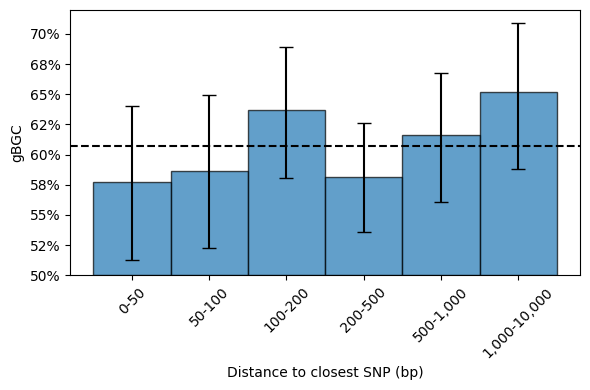

In [141]:
# Compute error bars
yerr = np.array([[h - low, high - h] for h, (low, high) in zip(biases, cis)]).T

bin_edges = np.array([0, 50, 100, 200, 500, 1000, 10000])

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.6  # Keeping bar width constant for visual consistency
ax.bar(
    #x = (bin_edges[:-1]+bin_edges[1:])/2, 
    x = np.arange(6)*2 + 1,
    height = np.array(biases) - 0.5, 
    width = 2,
    bottom = 0.5,
    yerr = yerr, 
    capsize = 5, 
    alpha=0.7,
    edgecolor='k')

# Labels and title
ax.set_xticks(
    ticks = np.arange(6)*2+1,
    labels = ["0-50", "50-100", "100-200", "200-500", "500-1,000", "1,000-10,000"],
    rotation=45,
)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.xlabel("Distance to closest SNP (bp)");
plt.ylabel("gBGC");
plt.axhline(0.607, c="black", ls="--");

# Show the plot
plt.tight_layout()
plt.show()

## Limit to multi-tracts with <50bp; vs. just SNPs with nearby 

In [39]:
multi_df_with_dist = (multi_df
    .group_by("read_name")
    .map_groups(lambda df: pl.DataFrame({
            "read_name": df["read_name"],
            "min_converted_snp_dist": np.diff(df["start"].sort().to_numpy()).min(),
        })
    )
    .unique()
)

In [40]:
calculate_gc_stats(
    multi_df.join(multi_df_with_dist.filter(pl.col("min_converted_snp_dist") <= 50), on="read_name"), 
    rahbari_sample_ids + sudmant_sample_ids
)

n_GC, n_AT: 63 31
GC-bias: 0.6702127659574468
CI: (0.569372042947651, 0.7617899435465761)


(0.6702127659574468, (0.569372042947651, 0.7617899435465761))

In [41]:
calculate_gc_stats(
    (converted_snps_with_seq_df
        .filter(pl.col("min_snp_diff") <= 50)
    ), 
    rahbari_sample_ids + sudmant_sample_ids,
)

n_GC, n_AT: 138 101
GC-bias: 0.5774058577405857
CI: (0.512570190394644, 0.6403799988436902)


(0.5774058577405857, (0.512570190394644, 0.6403799988436902))

In [42]:
scipy.stats.fisher_exact(
    [[63, 31], [138, 101]]
)

SignificanceResult(statistic=np.float64(1.4873772791023843), pvalue=np.float64(0.13582626083073143))

In [43]:
scipy.stats.fisher_exact(
    [[1103, 712], [138, 101]]
)

SignificanceResult(statistic=np.float64(1.1338035336264451), pvalue=np.float64(0.39853971577383307))

## More ranges

In [44]:
dist_bins = [[0, 50], [50, 100], [100, 200], [200, 500], [500, 1000], [1000, 10000]]

biases = []
cis = []
for h, l in tqdm.tqdm(dist_bins):
    b, ci = calculate_gc_stats(
        multi_df.join(multi_df_with_dist.filter(pl.col("min_converted_snp_dist").is_between(h, l)), on="read_name"),
        rahbari_sample_ids + sudmant_sample_ids,
    )
    biases.append(b)
    cis.append(ci)

  0%|          | 0/6 [00:00<?, ?it/s]

n_GC, n_AT: 63 31
GC-bias: 0.6702127659574468
CI: (0.569372042947651, 0.7617899435465761)


 33%|███▎      | 2/6 [00:00<00:00,  6.98it/s]

n_GC, n_AT: 15 18
GC-bias: 0.45454545454545453
CI: (0.2845806068291086, 0.6223920429263305)
n_GC, n_AT: 20 6
GC-bias: 0.7692307692307693
CI: (0.5778270380744888, 0.8944035510724829)
n_GC, n_AT: 11 12
GC-bias: 0.4782608695652174
CI: (0.27813098336659164, 0.6764575344328411)


 67%|██████▋   | 4/6 [00:00<00:00,  8.32it/s]

n_GC, n_AT: 14 11
GC-bias: 0.56
CI: (0.35744604027751015, 0.7440956754058241)


 83%|████████▎ | 5/6 [00:00<00:00,  7.99it/s]

n_GC, n_AT: 15 5
GC-bias: 0.75
CI: (0.5254305550873166, 0.8959191640898639)


100%|██████████| 6/6 [00:00<00:00,  8.28it/s]


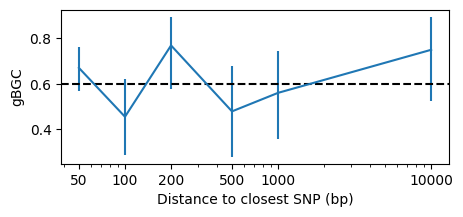

In [45]:
plt.figure(figsize=(5, 2));

plt.errorbar(
    x = [x[1] for x in dist_bins],
    y = biases,
    yerr = np.array([[b-ci[0], ci[1]-b] for b, ci in zip(biases, cis)]).T
)

plt.xscale("log");
plt.xticks(ticks=[x[1] for x in dist_bins], labels=[x[1] for x in dist_bins]);
plt.xlabel("Distance to closest SNP (bp)");
plt.ylabel("gBGC");
plt.axhline(0.6, c="black", ls="--");

## Motif erosion

In [46]:
# from Bio import SeqIO

# grch38_path = "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/02.grch38/Homo_sapiens_assembly38.fasta"
# grch38_seq = SeqIO.to_dict(SeqIO.parse(grch38_path, "fasta"))

In [13]:
import pyreadr

AA_motif = pyreadr.read_r('/lustre/scratch122/tol/projects/sperm/data/references/06.hotspots/hinch_2023_AA_motif.R')['pwm']
AA_motif.columns = ['A', 'C', 'G', 'T']

In [14]:
def score_motif(sequence, AA_motif=AA_motif):
    x = 0
    for i, n in enumerate(sequence):
        x += np.log(AA_motif[n].iloc[i])
    return x

In [15]:
def reverse_complement(seq):
    complement = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(complement)[::-1]

In [16]:
%%time
AA_hotspots_df = (
    pl.read_csv(
        "/lustre/scratch122/tol/projects/sperm/data/references/06.hotspots/hinch_2023_AA_hotspots.csv",
        infer_schema_length=10000,
    )
    .rename({"Chromosome": "chrom", "Motif_Centre_Pos": "AA_motif_center_pos"})
    .select("chrom", "AA_motif_center_pos", "motif", "motif_strand")
    .with_columns(
        revc_motif = pl.col("motif").map_elements(reverse_complement, return_dtype=pl.String)
    )
    .with_columns(
        aligned_motif = (
            pl.when(pl.col("motif_strand") == 1)
            .then(pl.col("motif").str.to_uppercase())
            .otherwise(pl.col("revc_motif").str.to_uppercase())
        )
    )
    .with_columns(
        motif_score = pl.col("aligned_motif").map_elements(score_motif, return_dtype=pl.Float64),
    )
)

CPU times: user 9.92 s, sys: 440 ms, total: 10.4 s
Wall time: 9.76 s


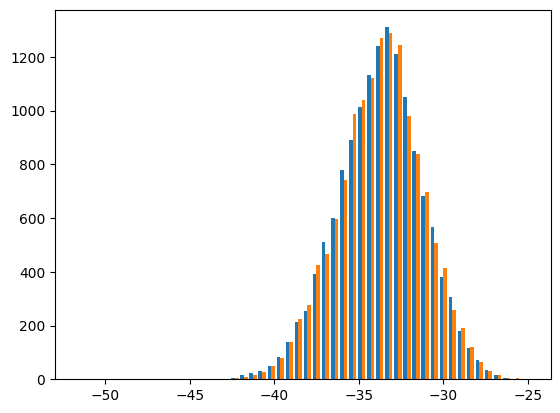

In [17]:
plt.hist([
    AA_hotspots_df.filter(pl.col("motif_strand") == 0)["motif_score"], 
    AA_hotspots_df.filter(pl.col("motif_strand") == 1)["motif_score"], 
],
bins=50);

In [18]:
converted_snps_with_seq_and_motifs_df = (NCO_df
    .filter(pl.col("AA_motif_center_pos").is_not_null())
    .join(AA_hotspots_df, on=["chrom", "AA_motif_center_pos"])
#    .with_columns(gc_content = pl.col("motif").str.slice(9, 13).str.count_matches("[gcGC]"))
    .select("read_name", "motif_score", "AA_motif_center_pos", "grch38_reference_start")
    .join(converted_snps_with_seq_df, on="read_name")
)

In [37]:
all_converted_snps_with_seq_and_motifs_df = (NCO_df
    .filter(pl.col("AA_motif_center_pos").is_not_null())
    .join(AA_hotspots_df, on=["chrom", "AA_motif_center_pos"])
#    .with_columns(gc_content = pl.col("motif").str.slice(9, 13).str.count_matches("[gcGC]"))
    .select("read_name", "motif_score", "AA_motif_center_pos", "grch38_reference_start", "aligned_motif")
    .join(all_converted_snps_with_seq_df, on="read_name")
)

In [21]:
len(all_converted_snps_with_seq_and_motifs_df)

1129

In [55]:
calculate_gc_stats(
    converted_snps_with_seq_and_motifs_df, 
    rahbari_sample_ids + sudmant_sample_ids,
)

n_GC, n_AT: 553 288
GC-bias: 0.6575505350772889
CI: (0.6243048146303324, 0.6891278936778733)


(0.6575505350772889, (0.6243048146303324, 0.6891278936778733))

In [56]:
calculate_gc_stats(
    converted_snps_with_seq_and_motifs_df.filter(pl.col("motif_score") > -30), 
    rahbari_sample_ids + sudmant_sample_ids,
)

n_GC, n_AT: 53 20
GC-bias: 0.726027397260274
CI: (0.6101697333873247, 0.8164603921289706)


(0.726027397260274, (0.6101697333873247, 0.8164603921289706))

In [57]:
calculate_gc_stats(
    converted_snps_with_seq_and_motifs_df.filter(pl.col("motif_score") < -37), 
    rahbari_sample_ids + sudmant_sample_ids,
)

n_GC, n_AT: 45 19
GC-bias: 0.703125
CI: (0.5785716690938164, 0.806682185135023)


(0.703125, (0.5785716690938164, 0.806682185135023))

In [58]:
xdf = (
    converted_snps_with_seq_and_motifs_df.select(
        "motif_score",
        pl.when(pl.col("fits1_more") == 1).then(pl.col("refseq_start1")).otherwise(pl.col("refseq_start2")).is_in(["G","C"]).cast(int).alias("is_gc_converted")
    )
)

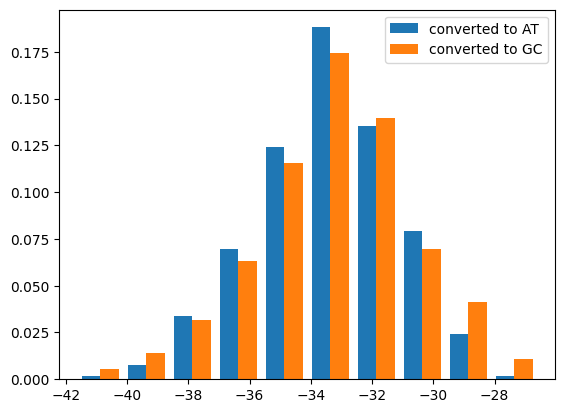

In [59]:
plt.hist(
    [
        xdf.filter(pl.col("is_gc_converted")==0)["motif_score"],
        xdf.filter(pl.col("is_gc_converted")==1)["motif_score"],
    ],
    density=True,
);

plt.legend(["converted to AT", "converted to GC"]);

In [60]:
scipy.stats.ttest_ind(
    xdf.filter(pl.col("is_gc_converted")==0)["motif_score"],
        xdf.filter(pl.col("is_gc_converted")==1)["motif_score"],
)

TtestResult(statistic=np.float64(-0.8356067869844752), pvalue=np.float64(0.40358341890334737), df=np.float64(963.0))

In [61]:
scipy.stats.pearsonr(
    xdf["motif_score"],
    xdf["is_gc_converted"],    
)

PearsonRResult(statistic=np.float64(0.026917295740640047), pvalue=np.float64(0.4035834189033447))

In [62]:
scipy.stats.spearmanr(
    xdf["motif_score"],
    xdf["is_gc_converted"],    
)

SignificanceResult(statistic=np.float64(0.028369917324754884), pvalue=np.float64(0.37868013811371504))

## Do any converted SNPs actually fall on motifs?

In [22]:
conversion_in_action_df = (converted_snps_with_seq_and_motifs_df
    .filter(
        (pl.col("grch38_reference_start") + pl.col("start")).is_between(pl.col("AA_motif_center_pos")-15, pl.col("AA_motif_center_pos")+15)
    )
)

In [24]:
len(conversion_in_action_df)

38

In [64]:
converted_snps_with_seq_and_motifs_df.head()

read_name,motif_score,AA_motif_center_pos,grch38_reference_start,sample_id,chrom,start,has_AA_DSB,snp_positions_on_read,refseq_start1,refseq_start2,fits1_more,min_snp_diff
str,f64,i64,i64,str,str,i64,bool,list[i64],str,str,i32,i64
"""m54329U_230211_064937/113052251/ccs""",-33.662848,138651311,138650830,"""NA12878""","""chr5""",2495,true,"[1358, 2419, … 21957]","""C""","""T""",1,76
"""m54329U_230311_094504/148244794/ccs""",-35.491666,162145629,162128694,"""NA12889""","""chr6""",13384,true,"[1122, 2190, … 21634]","""T""","""G""",1,766
"""m54329U_230311_094504/159975706/ccs""",-32.352899,19743834,19740281,"""NA12889""","""chr22""",11496,true,"[6013, 9808, … 12014]","""G""","""A""",1,518
"""m54329U_230311_094504/3148526/ccs""",-33.925986,8736044,8716360,"""NA12889""","""chr16""",11618,true,"[1769, 2444, … 19713]","""G""","""A""",1,115
"""m54329U_230311_094504/65470870/ccs""",-30.791903,19989902,19987059,"""NA12889""","""chr15""",9093,true,"[638, 946, … 17053]","""A""","""G""",0,4358


In [65]:
%%time
aln_filenames = (
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/alignments/{sample_set}/{sample_id}/{flow_cell}/{chrom}/grch38_variants_on_reads_at_mid_quality_events.parquet"
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set", "flow_cell").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + \
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/alignments/{sample_set}/{sample_id}/{flow_cell}/{chrom}/grch38_variants_on_reads_at_mid_quality_events.parquet"
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set", "flow_cell").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + \
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/alignments/{sample_set}/{sample_id}/{flow_cell}/{chrom}/grch38_variants_on_reads_at_mid_quality_events.parquet"
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(ceph_df.select("sample_id", "sample_set", "flow_cell").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)

56it [00:00, 137921.92it/s]
12it [00:00, 81707.22it/s]
52it [00:00, 139541.78it/s]

CPU times: user 12.5 ms, sys: 4.97 ms, total: 17.4 ms
Wall time: 5.43 ms


In [66]:
(
    pl.scan_parquet(
        aln_filenames[0]
    )
    .join(
        converted_snps_with_seq_and_motifs_df.select("read_name", "start").lazy(),
        on=["read_name", "start"],
    )
    .head()
    .collect()
)

read_name,start,ref_start,ref_seq
str,i64,i64,str


In [67]:
len(conversion_in_action_df)

38

In [68]:
calculate_gc_stats(
    conversion_in_action_df,
    rahbari_sample_ids + sudmant_sample_ids,
)

n_GC, n_AT: 24 14
GC-bias: 0.631578947368421
CI: (0.46529759938454796, 0.7738602284097615)


(0.631578947368421, (0.46529759938454796, 0.7738602284097615))

## Break conversion by all options

In [193]:
ydf = (all_converted_snps_with_seq_df
    .drop_nulls()
    .filter(pl.col("sample_id").is_in(rahbari_sample_ids + sudmant_sample_ids))
    .with_columns(
        seq_from = pl.when(pl.col("fits1_more") != 1).then(pl.col("refseq_start1")).otherwise(pl.col("refseq_start2")),
        seq_to   = pl.when(pl.col("fits1_more") == 1).then(pl.col("refseq_start1")).otherwise(pl.col("refseq_start2")),
    )
    .group_by("seq_from", "seq_to")
    .len()
    .sort("seq_from", "seq_to")
)

In [194]:
yd = {(x+y):n for x,y,n in ydf.rows()}

In [195]:
yd

{'AC': 117,
 'AG': 463,
 'AT': 46,
 'CA': 85,
 'CG': 83,
 'CT': 270,
 'GA': 275,
 'GC': 82,
 'GT': 82,
 'TA': 73,
 'TC': 413,
 'TG': 110}

### Same order as in Li et al

In [196]:
[
    yd["CA"]+yd["GT"],
    yd["GA"]+yd["CT"],
    yd["GC"]+yd["CG"],
    yd["AC"]+yd["TG"],
    yd["AG"]+yd["TC"],
    yd["TA"]+yd["AT"],
]

[167, 545, 165, 227, 876, 119]

### What to normalize against?

In [149]:
%%time
all_snps_df = (NCO_df
    .select(
        "sample_id",
        "chrom",
        "read_name",
        "snp_positions_on_read",
    )
    .explode("snp_positions_on_read")
    .rename({"snp_positions_on_read": "start"})
)

CPU times: user 209 μs, sys: 4.5 ms, total: 4.71 ms
Wall time: 2.32 ms


In [150]:
def F(filename):
    high_conf_snps_df = pl.scan_parquet(filename)
    
    df = (all_snps_df
            .lazy()
            .join(
                (high_conf_snps_df
                    .select(
                        "read_name",
                        "start",
                        "refseq_start1",
                        "refseq_start2",    
                        "fits1_more",
                    )
                ),
                on=["read_name", "start"],
            )
        ).collect()
    
    return df

dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(filename) for filename in filenames
)
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.3s
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while 

In [151]:
all_snps_with_seq_df = pl.concat(dfs)

In [152]:
len(all_snps_with_seq_df)

49356

In [154]:
closest_snp_to_converted_with_seq_df = (all_snps_with_seq_df
    .drop_nulls()
    .rename({"start": "other_snp"})
    .join(all_converted_snps_with_seq_df.drop_nulls(), on="read_name")
    .with_columns(
        diff_to_converted_snp = (pl.col("start") - pl.col("other_snp")).abs()
    )
    .filter(pl.col("diff_to_converted_snp") > 0)
    .sort("read_name", "diff_to_converted_snp")
    .group_by("read_name", maintain_order=True)
    .first()
)

In [197]:
zdf = (closest_snp_to_converted_with_seq_df
    .filter(pl.col("sample_id").is_in(rahbari_sample_ids + sudmant_sample_ids))
    .drop_nulls()
    .with_columns(
        seq_from = pl.when(pl.col("fits1_more") != 1).then(pl.col("refseq_start1")).otherwise(pl.col("refseq_start2")),
        seq_to   = pl.when(pl.col("fits1_more") == 1).then(pl.col("refseq_start1")).otherwise(pl.col("refseq_start2")),
    )
    .group_by("seq_from", "seq_to")
    .len()
    .sort("seq_from", "seq_to")
)

In [198]:
zd = {(x+y):n for x,y,n in zdf.rows()}

In [199]:
counts_at_converted_per_pair = np.array([
    yd["CA"]+yd["GT"],
    yd["GA"]+yd["CT"],
    yd["GC"]+yd["CG"],
    yd["AC"]+yd["TG"],
    yd["AG"]+yd["TC"],
    yd["TA"]+yd["AT"],
])

counts_near_converted_per_pair = np.array([
    zd["CA"]+zd["GT"],
    zd["GA"]+zd["CT"],
    zd["GC"]+zd["CG"],
    zd["AC"]+zd["TG"],
    zd["AG"]+zd["TC"],
    zd["TA"]+zd["AT"],
])

In [200]:
counts_at_converted_per_pair

array([167, 545, 165, 227, 876, 119])

In [201]:
counts_at_converted_per_pair_cis = np.array([
    statsmodels.stats.proportion.proportion_confint(x, np.sum(counts_at_converted_per_pair), method="binom_test")
    for x in counts_at_converted_per_pair
])

In [202]:
counts_at_converted_per_pair_cis

array([[0.06853899, 0.09189276],
       [0.24127015, 0.27891127],
       [0.06758244, 0.09093742],
       [0.09546541, 0.122149  ],
       [0.39636516, 0.43877145],
       [0.04733004, 0.06768696]])

In [203]:
counts_near_converted_per_pair

array([160, 641, 169, 135, 739,  94])

In [204]:
counts_near_converted_per_pair_cis = np.array([
    statsmodels.stats.proportion.proportion_confint(x, np.sum(counts_near_converted_per_pair), method="binom_test")
    for x in counts_near_converted_per_pair
])

In [205]:
counts_near_converted_per_pair_cis

array([[0.07087788, 0.09565602],
       [0.31008546, 0.35214442],
       [0.07526789, 0.10056026],
       [0.05901263, 0.08207647],
       [0.35988646, 0.40323625],
       [0.03965876, 0.05901263]])

In [206]:
total_cis = np.array([
    [min([xl/el, xl/eh, xh/el, xh/eh]), max([xl/el, xl/eh, xh/el, xh/eh])]
    for (xl,xh), (el,eh) in zip(counts_at_converted_per_pair_cis, counts_near_converted_per_pair_cis)
])

In [207]:
total_cis

array([[0.71651514, 1.29649409],
       [0.68514545, 0.8994658 ],
       [0.67205914, 1.20818342],
       [1.16312768, 2.06987887],
       [0.98296015, 1.21919411],
       [0.8020324 , 1.70673389]])

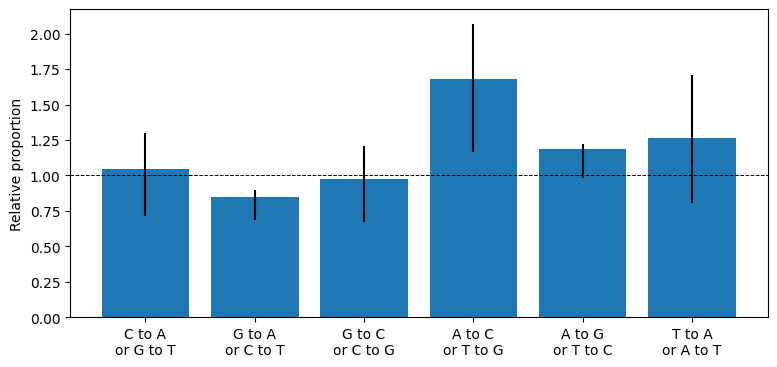

In [208]:
rel_props = np.array(counts_at_converted_per_pair) / np.array(counts_near_converted_per_pair)
yerr = np.array([[h - low, high - h] for h, (low, high) in zip(rel_props, total_cis)]).T

fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(
    x = np.arange(6), 
    height = rel_props,
    yerr = yerr,
)

ax.axhline(1, color="black", ls="--", lw=0.7);
ax.set_xticks(
    ticks = np.arange(6),
    labels = [
        "C to A\nor G to T", 
        "G to A\nor C to T", 
        "G to C\nor C to G", 
        "A to C\nor T to G", 
        "A to G\nor T to C", 
        "T to A\nor A to T",
    ]
);
ax.set_ylabel("Relative proportion");

## MP2: Near centromeres?

In [32]:
cyto_T2T_df = pl.read_csv(
    "http://t2t.gi.ucsc.edu/chm13/hub/t2t-chm13-v2.0/download/chm13v2.0_cytobands_allchrs.bed.gz",
    separator='\t',
    new_columns=["chrom", "cyto_start", "cyto_end", "cyto_name", "type"],
    has_header=False,
)

In [33]:
cent_df = cyto_T2T_df.filter(pl.col("type") == "acen")

In [37]:
dist_df = (NCO_df
    .join(cent_df, on="chrom")
    .with_columns(
        dist_to_cent = pl.min_horizontal(
            (pl.col("T2T_reference_start") - pl.col("cyto_start")).abs(),
            (pl.col("T2T_reference_start") - pl.col("cyto_end")).abs(),
        )
    )
    .select("chrom", "read_name", "dist_to_cent")
    .group_by("chrom", "read_name")
    .agg(pl.col("dist_to_cent").min())
)

In [80]:
resolution = 1e7

sdf = (dist_df
    .filter(pl.col("dist_to_cent") < 2 * resolution)
    .with_columns(
        rounded_dist_to_cent = (pl.col("dist_to_cent") // resolution).cast(int)
    )
    .group_by("chrom", "rounded_dist_to_cent")
    .len()
    .sort("chrom", "rounded_dist_to_cent")
    .pivot(
        on="rounded_dist_to_cent",
        index="chrom",
        values="len",
    )
    .fill_null(0)
)

display(sdf)

chrom,0,1
str,u32,u32
"""chr1""",8,11
"""chr10""",18,12
"""chr11""",13,11
"""chr12""",21,26
"""chr13""",17,5
"""chr14""",13,11
"""chr15""",10,9
"""chr16""",5,20
"""chr17""",16,17


In [81]:
scipy.stats.chi2_contingency(sdf.select('0', '1').to_numpy()).pvalue

np.float64(0.09491429279763758)

In [82]:
acro_chroms = ["chr13", "chr14", "chr15", "chr21", "chr22"]

In [85]:
display(sdf
    .with_columns(
        acro = pl.col("chrom").is_in(acro_chroms)
    )
    .group_by("acro")
    .sum()    
)

acro,chrom,0,1
bool,str,u32,u32
true,null,63,42
false,null,256,298


In [86]:
scipy.stats.chi2_contingency((sdf
    .with_columns(
        acro = pl.col("chrom").is_in(acro_chroms)
    )
    .group_by("acro")
    .sum()    
).select('0', '1').to_numpy()).pvalue

np.float64(0.012913653044685142)

## MP3: Hotspot erosion in action

In [38]:
all_conversion_in_action_df = (all_converted_snps_with_seq_and_motifs_df
    .filter(
        (pl.col("grch38_reference_start") + pl.col("start")).is_between(pl.col("AA_motif_center_pos")-15, pl.col("AA_motif_center_pos")+15)
    )
)

In [26]:
len(all_conversion_in_action_df)

42

In [32]:
len(all_converted_snps_with_seq_and_motifs_df
    .filter(
        (pl.col("grch38_reference_start") + pl.col("start")).is_between(pl.col("AA_motif_center_pos")-1, pl.col("AA_motif_center_pos")+15)
    )
)

21

In [42]:
all_conversion_in_action_df.head()

read_name,motif_score,AA_motif_center_pos,grch38_reference_start,aligned_motif,sample_id,chrom,start,has_AA_DSB,snp_positions_on_read,refseq_start1,refseq_start2,fits1_more
str,f64,i64,i64,str,str,str,i64,bool,list[i64],str,str,i32
"""m64229e_220912_125215/169149369/ccs""",-32.248972,104010276,103990107,"""TATCTCTCATACTTCTTCCACCCTTTCCCCC""","""PD50521b""","""chr4""",20172,true,"[578, 942, … 27904]","""C""","""T""",0
"""m84093_241004_184906_s3/229314217/ccs""",-35.187425,13844401,13834148,"""CAAACTTCCTAGAAGGATCTCCAGGACCACT""","""PD50521e""","""chr7""",10266,true,"[9954, 10266, … 15990]","""T""","""C""",0
"""m84093_241004_145012_s1/105385754/ccs""",-33.472912,9767893,9764762,"""CTGCCCCGGTGTGTGGACCCTCCAGGTCCCC""","""PD50521e""","""chr2""",3123,true,"[2412, 2477, … 3764]","""T""","""C""",1
"""m84093_241004_145012_s1/59836210/ccs""",-36.710488,18814241,18810367,"""ATCACATACAGATTCTGCCCCCAGCCCCACC""","""PD50521e""","""chr8""",3865,true,"[804, 874, … 13615]","""T""","""C""",0
"""m84098_240926_113650_s3/180161721/ccs""",-30.946036,72390009,72382795,"""CCCCTCTCCTTTTCCTGCCCTCTTCTCCACT""","""PD50521e""","""chr4""",7203,true,"[1088, 1443, … 8233]","""T""","""G""",0


In [58]:
res = []
for row in all_conversion_in_action_df.iter_rows(named=True):
    position_of_snp_in_motif = (row["grch38_reference_start"] + row["start"]) - (row["AA_motif_center_pos"] - 15)
    
    original_allele = (row["refseq_start2"] if row["fits1_more"] else row["refseq_start1"])
    original_motif = list(row["aligned_motif"])
    original_motif[position_of_snp_in_motif] = original_allele
    original_score = score_motif(''.join(original_motif))
    
    other_allele    = (row["refseq_start1"] if row["fits1_more"] else row["refseq_start2"])
    other_motif = list(row["aligned_motif"])
    other_motif[position_of_snp_in_motif] = other_allele
    other_score = score_motif(''.join(other_motif))
    
    res.append([row["read_name"], original_score, other_score])
    
scores_df = pl.DataFrame(
    res,
    schema = ["read_name", "original_score", "other_score"],
    orient = "row",
)
    


In [59]:
scores_df.select(pl.col("original_score") > pl.col("other_score")).sum()

original_score
u32
22


In [56]:
scipy.stats.binomtest(26, 42, 0.5)

BinomTestResult(k=26, n=42, alternative='two-sided', statistic=0.6190476190476191, pvalue=0.16414940178310644)

## MP5: PRDM9 motifs

In [9]:
rr_df = (
    pl.read_csv("/lustre/scratch122/tol/projects/sperm/analysis/prmd9_motif_analysis/randomly_sampled_reads.meme_annotated.csv")
    .select("read_name", pl.col("prdm9_intervals").is_not_null().alias("has_motif"))
)

In [27]:
def F(filename):
    return (
        pl.scan_parquet(filename)
        .join(rr_df.lazy(), on="read_name")
        .collect()
    )

rahbari_dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
    )
    for chrom in aut_chrom_names
    for sample_set, sample_id in rahbari_df.select("sample_set", "sample_id").unique().iter_rows()
)

sudmant_dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(
        f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
    )
    for chrom in aut_chrom_names
    for sample_set, sample_id in sudmant_df.select("sample_set", "sample_id").unique().iter_rows()
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:   31.1s finished


In [29]:
(pl.concat(rahbari_dfs + sudmant_dfs)    
    .filter(pl.col("AA_motif_center_pos").is_null())
    .select(
        pl.col("has_motif").mean(), 
        pl.col("has_motif").sum().alias("total"),
        pl.col("has_motif").len().alias("len"),
    )
)

has_motif,total,len
f64,u32,u32
0.249283,17293,69371


# Reviewer 2

## P1: BQ of converted SNPs vs. flanking SNPs

### Rahabri

In [11]:
%%time
import glob

def F(sample_set, sample_id, flow_cell, flow_cell_type, filename_glob):
    return (
        pl.scan_parquet(glob.glob(filename_glob))
        .with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .join(
            (NCO_df
                .filter(pl.col("sample_id") == sample_id)
                .select("read_name", "sample_id")
                .lazy()
            ),
            on=["read_name", "sample_id"],
        )
        .collect(streaming=True)
    )

#rahbari_nco_ann_snps_df = 
dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(
        sample_set, 
        sample_id, 
        flow_cell,
        flow_cell_type,
        str(
            Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212") / \
                f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        )
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in rahbari_df.iter_rows()
)

rahbari_nco_ann_snps_df = pl.concat(dfs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min


CPU times: user 1.35 s, sys: 1.01 s, total: 2.36 s
Wall time: 2min 47s


[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  2.8min finished


In [41]:
converted_snps_df = (rahbari_nco_ann_snps_df
    .group_by("sample_id", "read_name", "op1", "op2")
    .agg(
        qual = pl.col("qual_start1").first(),
        converted_pos = pl.col("start").first(),
        n_snps_per_side = pl.col("qual_start1").len(),
    )
    .filter((pl.col("op1") == 7) | (pl.col("op2") == 7))
    .sort("read_name", "n_snps_per_side")
    .unique(subset=["read_name"], keep="first")
    .filter(pl.col("n_snps_per_side") == 1)
)

In [42]:
tdf = (rahbari_nco_ann_snps_df
    .join(
        converted_snps_df.select("sample_id", "read_name", "qual", "converted_pos"),
        on=["sample_id", "read_name"],
    )
    .with_columns(
        dist_from_converted_snp = pl.col("converted_pos") - pl.col("start")
    )
)

In [43]:
flanking_before_snps_df = (tdf
    .filter(pl.col("dist_from_converted_snp") < 0)
    .sort("read_name", "dist_from_converted_snp")
    .group_by("read_name", maintain_order=True)
    .agg(
        pl.col("qual_start1").last().alias("qual_before_snp"),
    )
)

flanking_after_snps_df = (tdf
    .filter(pl.col("dist_from_converted_snp") > 0)
    .sort("read_name", "dist_from_converted_snp")
    .group_by("read_name", maintain_order=True)
    .agg(
        pl.col("qual_start1").first().alias("qual_after_snp"),
    )
)

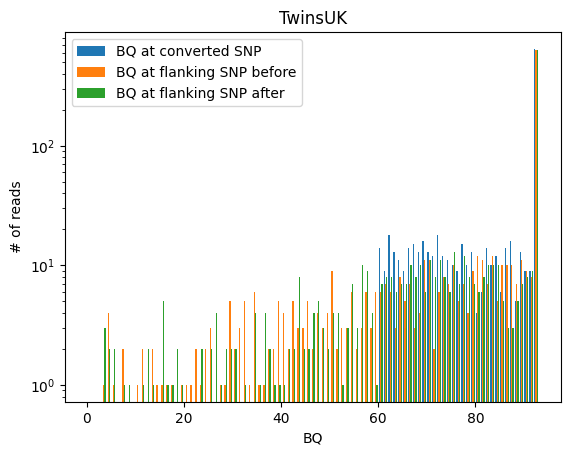

In [44]:
plt.hist(
    [
        converted_snps_df["qual"], 
        flanking_before_snps_df["qual_before_snp"], 
        flanking_after_snps_df["qual_after_snp"], 
    ],
    bins=np.arange(94),
    log=True,
);

plt.legend([
    "BQ at converted SNP",
    "BQ at flanking SNP before",
    "BQ at flanking SNP after",
]);

plt.xlabel("BQ");
plt.ylabel("# of reads");
plt.title("TwinsUK");

In [45]:
print(converted_snps_df["qual"].mean())
print(flanking_before_snps_df["qual_before_snp"].mean())
print(flanking_after_snps_df["qual_after_snp"].mean())
print((converted_snps_df["qual"]>=flanking_before_snps_df["qual_before_snp"]).mean())
print((converted_snps_df["qual"]>=flanking_after_snps_df["qual_after_snp"]).mean())

86.20570866141732
81.69094488188976
81.70669291338582
0.7244094488188977
0.7303149606299213


In [50]:
print("% of top BQ:", (converted_snps_df["qual"] == 93).mean())
print("% of top BQ before:", (flanking_before_snps_df["qual_before_snp"] == 93).mean())
print("% of top BQ after:", (flanking_after_snps_df["qual_after_snp"] == 93).mean())

% of top BQ: 0.6210629921259843
% of top BQ before: 0.6181102362204725
% of top BQ after: 0.6161417322834646


### SL

In [16]:
%%time
import glob

def F(sample_set, sample_id, flow_cell, flow_cell_type, filename_glob):
    return (
        pl.scan_parquet(glob.glob(filename_glob))
        .with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .join(
            (NCO_df
                .filter(pl.col("sample_id") == sample_id)
                .select("read_name", "sample_id")
                .lazy()
            ),
            on=["read_name", "sample_id"],
        )
        .collect(streaming=True)
    )

#rahbari_nco_ann_snps_df = 
dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(
        sample_set, 
        sample_id, 
        flow_cell,
        flow_cell_type,
        str(
            Path("/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121") / \
                f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        )
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in sudmant_df.iter_rows()
)

sudmant_nco_ann_snps_df = pl.concat(dfs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   56.9s remaining:   40.6s


CPU times: user 318 ms, sys: 195 ms, total: 514 ms
Wall time: 1min 8s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.1min finished


In [51]:
converted_snps_df = (sudmant_nco_ann_snps_df
    .group_by("sample_id", "read_name", "op1", "op2")
    .agg(
        qual = pl.col("qual_start1").first(),
        converted_pos = pl.col("start").first(),
        n_snps_per_side = pl.col("qual_start1").len(),
    )
    .filter((pl.col("op1") == 7) | (pl.col("op2") == 7))
    .sort("read_name", "n_snps_per_side")
    .unique(subset=["read_name"], keep="first")
    .filter(pl.col("n_snps_per_side") == 1)
)

In [52]:
tdf = (sudmant_nco_ann_snps_df
    .join(
        converted_snps_df.select("sample_id", "read_name", "qual", "converted_pos"),
        on=["sample_id", "read_name"],
    )
    .with_columns(
        dist_from_converted_snp = pl.col("converted_pos") - pl.col("start")
    )
)

In [53]:
flanking_before_snps_df = (tdf
    .filter(pl.col("dist_from_converted_snp") < 0)
    .sort("read_name", "dist_from_converted_snp")
    .group_by("read_name", maintain_order=True)
    .agg(
        pl.col("qual_start1").last().alias("qual_before_snp"),
    )
)

flanking_after_snps_df = (tdf
    .filter(pl.col("dist_from_converted_snp") > 0)
    .sort("read_name", "dist_from_converted_snp")
    .group_by("read_name", maintain_order=True)
    .agg(
        pl.col("qual_start1").first().alias("qual_after_snp"),
    )
)

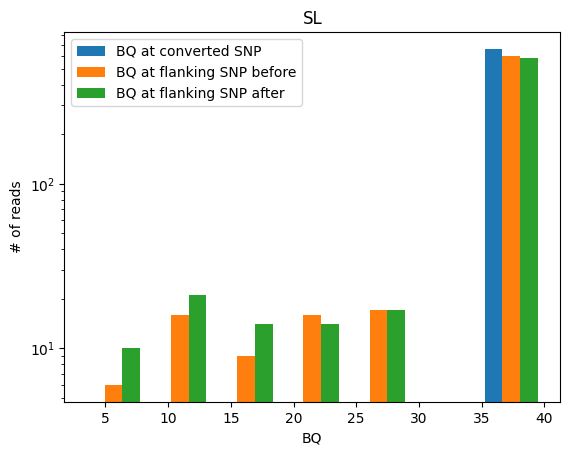

In [54]:
plt.hist(
    [
        converted_snps_df["qual"], 
        flanking_before_snps_df["qual_before_snp"], 
        flanking_after_snps_df["qual_after_snp"], 
    ],
    bins=7,
    log=True,
);

plt.legend([
    "BQ at converted SNP",
    "BQ at flanking SNP before",
    "BQ at flanking SNP after",
]);

plt.xlabel("BQ");
plt.ylabel("# of reads");
plt.title("SL");

In [55]:
print(converted_snps_df["qual"].mean())
print(flanking_before_snps_df["qual_before_snp"].mean())
print(flanking_after_snps_df["qual_after_snp"].mean())
print((converted_snps_df["qual"]>=flanking_before_snps_df["qual_before_snp"]).mean())
print((converted_snps_df["qual"]>=flanking_after_snps_df["qual_after_snp"]).mean())

40.0
37.442424242424245
36.90151515151515
1.0
1.0


In [57]:
print("% of top BQ:", (converted_snps_df["qual"] == 40).mean())
print("% of top BQ before:", (flanking_before_snps_df["qual_before_snp"] == 40).mean())
print("% of top BQ after:", (flanking_after_snps_df["qual_after_snp"] == 40).mean())

% of top BQ: 1.0
% of top BQ before: 0.8212121212121212
% of top BQ after: 0.8090909090909091


In [58]:
(0.82121212121212+0.80909090909)/2

0.81515151515106